# Creating a large database

In this section, we will take a look at techniques for creating a database for a large file or number of files.

In [7]:
import pandas as pd
from dfply import *

## Creating a large database with `pandas`

1. Read the first chunk and build cleaning functions.
2. Write the first section to a `db`
3. Use a for loop to <br>
    a. read a chuck<br>
    b. clean the chunk<br>
    c. append the chunk to the `db`<br>

## Example - Creating a Uber database with dateparts

Now we will use `pandas` to read, process and write the Uber data to a database.

## Step 1 - Inspect/clean the first chunk

It is important to automate the type specification and cleaning process. (based on previous work shown above)

#### Imports

In [8]:
from toolz import first
from calendar import day_name
import numpy as np
import pandas as pd
from dfply import *

#### default values

In [9]:
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

#### Create a data frame iterator and pull off the first chunk

In [10]:
c_size = 10000
file = "./data/uber-raw-data-apr14.csv"
df_iter = pd.read_csv(file, 
                      header=0, names=new_names,
                      parse_dates=date_cols,
                      sep=',',
                      engine='python',
                      chunksize=c_size)
first_chunk = next(df_iter)
first_chunk.head()

,date,lat,lon,base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


#### Expression for adding various date parts

In [11]:
from functoolz import pipeable
(first_chunk 
 >> mutate(weekday = X.date.dt.weekday_name,
           weekofyear = X.date.dt.weekofyear,
           dayofyear = X.date.dt.dayofyear,
           year = X.date.dt.year,
           month = X.date.dt.month_name(),
           day = X.date.dt.day,
           hour = X.date.dt.hour)
 >> head)

,date,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,14,91,2014,April,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,14,91,2014,April,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,14,91,2014,April,1,0


#### Create a functions for adding dateparts

In [12]:
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour)
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0


## Adding a primary key

* **Recall:** Primary keys need to be unique
* We will need to adjust the `id` column
* Make sure first `id` of next chunk is one more than the last

#### A function for adding an `id` column with a given starting value

In [13]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))

#### Playing around with different chunk indices

In [14]:
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,0


In [15]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


In [16]:
i = 1
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,10000


In [17]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,19999


In [18]:
i = 2
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,20000


In [19]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,29999


#### Compose the helper functions

In [21]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
first_chunk >> process_chunk(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


#### Get the `sqlalchemy` types

In [22]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'base': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer,
 'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'month': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer}

## Step 2 - Read, process, and write the first chunk

Use `if_exists='replace'` on this first chuck.

#### Create a new database

In [23]:
!rm ./databases/uber.db

rm: ./databases/uber.db: No such file or directory


In [35]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

#### Get the sql schema and create the table

In [190]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




OperationalError: (sqlite3.OperationalError) table uber already exists [SQL: '\nCREATE TABLE uber (\n\tlat FLOAT, \n\tlon FLOAT, \n\tbase VARCHAR, \n\tweekday VARCHAR, \n\tweekofyear INTEGER, \n\tdayofyear INTEGER, \n\tyear INTEGER, \n\tmonth VARCHAR, \n\tday INTEGER, \n\thour INTEGER, \n\tid INTEGER NOT NULL, \n\tCONSTRAINT uber_pk PRIMARY KEY (id)\n)\n\n']

## Step 3 - Getting the `df` iterator and read in each processed chunk


In [37]:
c_size = 10000
df_iter = enumerate(pd.read_csv("./data/uber-raw-data-apr14.csv", 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [38]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0


IntegrityError: (sqlite3.IntegrityError) UNIQUE constraint failed: uber.id [SQL: 'INSERT INTO uber (lat, lon, base, weekday, weekofyear, dayofyear, year, month, day, hour, id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'] [parameters: ((40.769, -73.9549, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 0), (40.7267, -74.0345, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 1), (40.7316, -73.9873, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 2), (40.7588, -73.9776, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 3), (40.7594, -73.9722, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 4), (40.7383, -74.0403, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 5), (40.7223, -73.9887, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 6), (40.762, -73.979, 'B02512', 'Tuesday', 14, 91, 2014, 'April', 1, 0, 7)  ... displaying 10 of 10000 total bound parameter sets ...  (40.7648, -73.9663, 'B02512', 'Tuesday', 15, 98, 2014, 'April', 8, 19, 9998), (40.7656, -73.9697, 'B02512', 'Tuesday', 15, 98, 2014, 'April', 8, 19, 9999))]

## Step 4 - Query the database to test the results


In [39]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [40]:
from sqlalchemy import select, func
stmt = (select([Uber.weekday, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,weekday,cnt
0,Friday,90303
1,Monday,60861
2,Saturday,77218
3,Sunday,51251
4,Thursday,85067
5,Tuesday,91185
6,Wednesday,108631


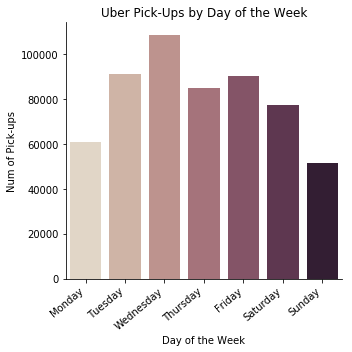

In [41]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               order=day_name,
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 3 </font>

Add the data from the other 5 months to the database.  To do this

1. Use `glob` to get all the file names (filter out april).
2. Write a double `for` loop where
    a. The outer loop is over the file names
    b. The inner loop write each file, in chunks, to the database.
3. You will need keep track of the number of rows added using an accumulator.


Compute and visualize the hourly frequencies for Uber pick-ups for all 6 months, this time with `SQL` queries.

**Hint:** Recall that the primary key column, `id`, needs unique values.  You will need to adjust the `id` column in each chunk using `rows_so_far` (see below).

In [44]:
rows_so_far = cnts.cnt.sum()
rows_so_far

564516

In [83]:
# Your code here
from glob import glob
files = glob('./data/uber/uber-trip-data/*.csv')
files

['./data/uber/uber-trip-data/taxi-zone-lookup.csv',
 './data/uber/uber-trip-data/uber-raw-data-apr14.csv',
 './data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv']

In [160]:
file1 = files[2:]
file1

['./data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv']

In [141]:
import re
from functools import reduce
FILE_NAME_RE = re.compile(r'^\./data/uber/uber-trip-data/uber-raw-data-(may|jun|jul|aug|sep)14\.csv$')
file_name = lambda p: FILE_NAME_RE.findall(p)
file_names = lambda files: [file_name(p) for p in files if file_name(p) != None]
file_names(files)



[[], [], ['aug'], ['sep'], ['jul'], ['jun'], ['may']]

In [142]:
filename = reduce(lambda x,y: x+y,file_names(files))
filename

['aug', 'sep', 'jul', 'jun', 'may']

In [145]:
dfa = {name:pd.read_csv(path) for name, path in zip(filename, file)}
#[{name:path} for name, path in zip(filename,file)]
dfa

{'aug':                  Date/Time      Lat      Lon    Base
 0         8/1/2014 0:03:00  40.7366 -73.9906  B02512
 1         8/1/2014 0:09:00  40.7260 -73.9918  B02512
 2         8/1/2014 0:12:00  40.7209 -74.0507  B02512
 3         8/1/2014 0:12:00  40.7387 -73.9856  B02512
 4         8/1/2014 0:12:00  40.7323 -74.0077  B02512
 5         8/1/2014 0:13:00  40.7349 -74.0033  B02512
 6         8/1/2014 0:15:00  40.7279 -73.9542  B02512
 7         8/1/2014 0:17:00  40.7210 -73.9937  B02512
 8         8/1/2014 0:19:00  40.7195 -74.0060  B02512
 9         8/1/2014 0:20:00  40.7448 -73.9799  B02512
 10        8/1/2014 0:21:00  40.7399 -74.0057  B02512
 11        8/1/2014 0:25:00  40.7651 -73.9683  B02512
 12        8/1/2014 0:27:00  40.7354 -74.0081  B02512
 13        8/1/2014 0:29:00  40.7339 -74.0028  B02512
 14        8/1/2014 0:29:00  40.7364 -74.0301  B02512
 15        8/1/2014 0:29:00  40.7364 -74.0301  B02512
 16        8/1/2014 0:30:00  40.7252 -73.9516  B02512
 17        8/1/2014 0

In [150]:
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

In [205]:
for a in file1:
    for b in a:
        c_size = 10000
        file = a
        df_iter = pd.read_csv(file, chunksize=c_size, sep=',',header=0,names=new_names,
                    parse_dates=date_cols,engine='python')



first_chunk = next(df_iter)
first_chunk.head()


,date,lat,lon,base
0,2014-05-01 00:02:00,40.7521,-73.9914,B02512
1,2014-05-01 00:06:00,40.6965,-73.9715,B02512
2,2014-05-01 00:15:00,40.7464,-73.9838,B02512
3,2014-05-01 00:17:00,40.7463,-74.0011,B02512
4,2014-05-01 00:17:00,40.7594,-73.9734,B02512


In [193]:
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour)
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7521,-73.9914,B02512,Thursday,18,121,2014,May,1,0
1,40.6965,-73.9715,B02512,Thursday,18,121,2014,May,1,0


In [194]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(rows_so_far, rows_so_far + len(df))
                                              )))

In [196]:
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.7521,-73.9914,B02512,Thursday,18,121,2014,May,1,0,564516


In [197]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7611,-73.9744,B02512,Thursday,19,128,2014,May,8,19,574515


In [198]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
first_chunk >> process_chunk(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7611,-73.9744,B02512,Thursday,19,128,2014,May,8,19,574515


In [199]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk1 = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk1)
sql_types

{'base': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer,
 'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'month': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer}

In [217]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

In [218]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




OperationalError: (sqlite3.OperationalError) table uber already exists [SQL: '\nCREATE TABLE uber (\n\tlat FLOAT, \n\tlon FLOAT, \n\tbase VARCHAR, \n\tweekday VARCHAR, \n\tweekofyear INTEGER, \n\tdayofyear INTEGER, \n\tyear INTEGER, \n\tmonth VARCHAR, \n\tday INTEGER, \n\thour INTEGER, \n\tid INTEGER NOT NULL, \n\tCONSTRAINT uber_pk PRIMARY KEY (id)\n)\n\n']

In [212]:
for a in file1:
    for b in a:
        c_size = 10000
        file = a
        df_iterr = enumerate(pd.read_csv(file, chunksize=c_size, sep=',',header=0,names=new_names,
                    parse_dates=date_cols,engine='python'))

In [213]:
for i, chunk in df_iterr:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0


IntegrityError: (sqlite3.IntegrityError) UNIQUE constraint failed: uber.id [SQL: 'INSERT INTO uber (lat, lon, base, weekday, weekofyear, dayofyear, year, month, day, hour, id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'] [parameters: ((40.7521, -73.9914, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564516), (40.6965, -73.9715, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564517), (40.7464, -73.9838, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564518), (40.7463, -74.0011, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564519), (40.7594, -73.9734, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564520), (40.7685, -73.8625, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564521), (40.7637, -73.9962, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564522), (40.7252, -74.0023, 'B02512', 'Thursday', 18, 121, 2014, 'May', 1, 0, 564523)  ... displaying 10 of 10000 total bound parameter sets ...  (40.7451, -73.9942, 'B02512', 'Thursday', 19, 128, 2014, 'May', 8, 19, 574514), (40.7611, -73.9744, 'B02512', 'Thursday', 19, 128, 2014, 'May', 8, 19, 574515))]

In [214]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [215]:
from sqlalchemy import select, func
stmt = (select([Uber.weekday, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,weekday,cnt
0,Friday,91770
1,Monday,62034
2,Saturday,78505
3,Sunday,52141
4,Thursday,87746
5,Tuesday,92468
6,Wednesday,109852
